## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [14]:
import string
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, Input, LSTM
from tensorflow.keras.models import Sequential

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

В качестве текста для обучения выберем Шекспира

In [39]:
# Поскольку файл уже скачан прочитаем его и сохраним в переменную
with open('data/brodskiy.txt', 'r', encoding='ansi') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]
text = [x.replace('\xa0', '') for x in text]
text = [x.replace('#', '') for x in text]
text = [x.replace('I', '') for x in text]
text = [x.replace('V', '') for x in text]
text = [x.replace('X', '') for x in text]
# text = [x.replace('>', '') for x in text]
# Посмотрим как выглядит текст сейчас
text[-15:]

['\n',
 '\n',
 '\n',
 '\n',
 'Есть города, в которые нет возврата.\n',
 'Солнце бьется в их окна, как в гладкие зеркала. То\n',
 'есть, в них не проникнешь ни за какое злато.\n',
 'Там всегда протекает река под шестью мостами.\n',
 'Там есть места, где припадал устами\n',
 'тоже к устам и пером к листам. И\n',
 'там рябит от аркад, колоннад, от чугунных пугал;\n',
 'там толпа говорит, осаждая трамвайный угол,\n',
 'на языке человека, который убыл.\n',
 '\n',
 '1976']

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [40]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text)

# Посмотрим как выглядит текст после преобразований
text[-60:]

'ждая трамвайный угол,\nна языке человека, который убыл.\n\n1976'

Put all the characters, that you've seen in the text, into variable `tokens`.

In [42]:
tokens = sorted(set(text))
# Проверим корректность
len(tokens)
#tokens

100

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [43]:
# Создадим словарь dict <index>:<char>
idx_to_token = {}
# Пройдемся по каждому элементу списка токенов и присвоим индекс
for i in range(len(tokens)):
    idx_to_token[i] = tokens[i]

# Создадим также массив для хранения токенов, для удобства обращения
idx_to_token_np = np.array(tokens)

# Аналогично словарю выше, но меняются местами индексы и символы dict <char>:<index>
token_to_idx = {}
for i in range(len(tokens)):
    token_to_idx[tokens[i]] = i
    
# Преобразуем весь текст в индексы
text_as_int = np.array([token_to_idx[c] for c in text])
text_as_int[-10:]

array([67, 93, 77,  7,  0,  0,  9, 17, 15, 14])

In [44]:
seq_length = 100

# преобразование кодировок text_as_int в тензоры
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

# посмотрим как это выглядит
[idx_to_token[int(i)] for i in char_dataset.take(10)]

['2', '4', ' ', 'д', 'е', 'к', 'а', 'б', 'р', 'я']

In [45]:
# Разобьем наш документ на обучающие последовательности
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
[repr(''.join(idx_to_token_np[item.numpy()])) for item in sequences.take(5)]

["'24 декабря 1971 года\\n\\n\\nВ Рождество все немного волхвы.\\nВ продовольственных слякоть и давка.\\nИз-за бан'",
 "'ки кофейной халвы\\nпроизводит осаду прилавка\\nгрудой свертков навьюченный люд:\\nкаждый сам себе царь и в'",
 "'ерблюд.\\n\\nСетки, сумки, авоськи, кульки,\\nшапки, галстуки, сбитые набок.\\nЗапах водки, хвои и трески,\\nма'",
 "'ндаринов, корицы и яблок.\\nХаос лиц, и не видно тропы\\nв Вифлеем из-за снежной крупы.\\n\\nИ разносчики скр'",
 "'омных даров\\nв транспорт прыгают, ломятся в двери,\\nисчезают в провалах дворов,\\nдаже зная, что пусто в '"]

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [46]:
# Создадим входную и таргетовую последовательности
# таргетовая это входная смещенная на 1 вправо
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)
# Так выглядит получившаяся последовательность в цифровом представлении
list(dataset)[0]

(<tf.Tensor: shape=(100,), dtype=int32, numpy=
 array([10, 12,  1, 70, 71, 76, 66, 67, 82, 97,  1,  9, 17, 15,  9,  1, 69,
        80, 70, 66,  0,  0,  0, 39,  1, 53, 80, 72, 70, 71, 83, 84, 68, 80,
         1, 68, 83, 71,  1, 79, 71, 78, 79, 80, 69, 80,  1, 68, 80, 77, 87,
        68, 93,  7,  0, 39,  1, 81, 82, 80, 70, 80, 68, 80, 77, 94, 83, 84,
        68, 71, 79, 79, 93, 87,  1, 83, 77, 97, 76, 80, 84, 94,  1, 74,  1,
        70, 66, 68, 76, 66,  7,  0, 45, 73,  6, 73, 66,  1, 67, 66])>,
 <tf.Tensor: shape=(100,), dtype=int32, numpy=
 array([12,  1, 70, 71, 76, 66, 67, 82, 97,  1,  9, 17, 15,  9,  1, 69, 80,
        70, 66,  0,  0,  0, 39,  1, 53, 80, 72, 70, 71, 83, 84, 68, 80,  1,
        68, 83, 71,  1, 79, 71, 78, 79, 80, 69, 80,  1, 68, 80, 77, 87, 68,
        93,  7,  0, 39,  1, 81, 82, 80, 70, 80, 68, 80, 77, 94, 83, 84, 68,
        71, 79, 79, 93, 87,  1, 83, 77, 97, 76, 80, 84, 94,  1, 74,  1, 70,
        66, 68, 76, 66,  7,  0, 45, 73,  6, 73, 66,  1, 67, 66, 79])>)

In [47]:
# Так выглядит получившаяся последовательность в буквенном представлении
for input_example, target_example in dataset.take(1):
    print ('Input data: ', repr(''.join(idx_to_token_np[input_example.numpy()])))
    print ('Target data:', repr(''.join(idx_to_token_np[target_example.numpy()])))

Input data:  '24 декабря 1971 года\n\n\nВ Рождество все немного волхвы.\nВ продовольственных слякоть и давка.\nИз-за ба'
Target data: '4 декабря 1971 года\n\n\nВ Рождество все немного волхвы.\nВ продовольственных слякоть и давка.\nИз-за бан'


In [48]:
# Гиперпараметры для модели
BATCH_SIZE = 64
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

vocab_size = len(tokens)
embedding_dim = 256
rnn_units = 1024

In [49]:
clear_session()

In [50]:
# Функция для генерации текста 
def generate_text(start_string='паровоз', temp=1.0, gen_chars=100): 
    # Построим новую модель, используя только 1 вход 
    # заранее разделим на 2 модели vanilla_rnn и lstm
    model_pred = Sequential()
    model_pred.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    
    model_pred.add(LSTM(
        rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer='glorot_uniform'))
    
    model_pred.add(Dense(vocab_size))
    model_pred.build(input_shape=(1, None))
    # Загрузим ранее обученные веса
    model_pred.load_weights('model/lstm_brodskiy.weights.h5') 
    
    input_eval = [token_to_idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)  
    text_generated = []
    
    # Побуквенно генерируем сообщение от нейросети
    for i in range(gen_chars):
        predictions = model_pred(input_eval)      
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temp
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx_to_token_np[predicted_id])  
    return (start_string + ''.join(text_generated))

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [51]:
# Создаем новую модель
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model_lstm.add(LSTM(
    rnn_units,
    return_sequences=True,
    stateful=True,
    recurrent_initializer='glorot_uniform'))
model_lstm.add(Dense(vocab_size))

In [52]:
# Скомпелируем модель
model_lstm.compile(optimizer='adam', 
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

# Обучим модель
history = model_lstm.fit(dataset, epochs=50)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - loss: 4.1674
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - loss: 3.3889
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 3.1829
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 2.9882
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 2.8677
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - loss: 2.7845
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - loss: 2.7393
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 2.6887
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 2.6568
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 2.6140
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - loss: 2.5877
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - loss: 2.5650
Epoch 13/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - loss: 2.5309
Epoch 14/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5351s 486s/step - loss: 2.5148
Epoch 15/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - loss: 2.4966


In [59]:
# Обучим модель
history = model_lstm.fit(dataset, epochs=50)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - loss: 0.4551
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 0.4380
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - loss: 0.4268
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - loss: 0.4211
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - loss: 0.4105
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - loss: 0.3955
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - loss: 0.3909
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - loss: 0.3766
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - loss: 0.3727
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - loss: 0.3586
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - loss: 0.3565
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - loss: 0.3430
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - loss: 0.3379
Epoch 14/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - loss: 0.3389
Epoch 15/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - loss: 0.3240
Epoch 16/50
12/12 ━

In [60]:
# Также сохраним веса
model_lstm.save_weights('model/lstm_brodskiy.weights.h5')

# Посмотрим на сгенерированный текст и узнаем, что эта модель думает о любви
generated_text = generate_text("любовь это", 0.5, 200)
print(generated_text)

любовь это

дирейней луны, чтоби своей щекой
к неги скаты то ли раматы
и у мысли цепляются другим гаремом,
посалась с брюнетью.
Тробу растения. В облаках
тот же гудящий бомбардировщик,
летящий неведомо что бомб


Plot the loss function of the number of epochs. Does the final loss become better?

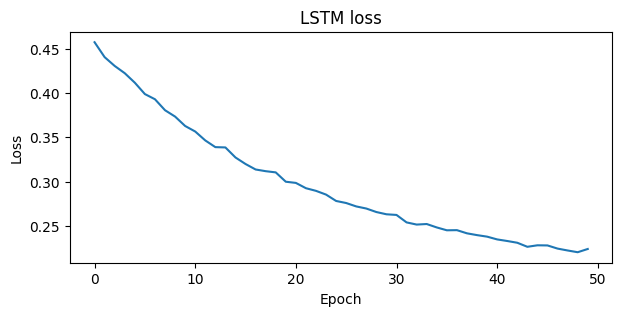

In [61]:
plt.style.use(['default'])
fig, ax = plt.subplots(figsize=(7,3), nrows=1, ncols=1)
# Построим график потерь в зависимости от эпохи
ax.plot(history.history['loss'])
ax.set_title('LSTM loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.show()

Вторая модель (LSTM) имеет преимущества по сравнению с первой (vanila_RNN), она обучалась 100 эпох, когда первая обучилась на 50, но тем не менее результаты второй модели на 50 эпохах в плане функции потерь лучше, чем у первой.

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [62]:
print('Text generated by LSTM')
print('<><><><><><><><><><><><>')

generated_text = generate_text("любовь это", 0.1, 300)
print('Generated text with 0.1 temprature:')
print(generated_text)
print('-----------------------')

generated_text = generate_text("любовь это", 0.2, 300)
print('Generated text with 0.2 temprature:')
print(generated_text)
print('-----------------------')

# generated_text = generate_text("любовь это", 1.0, 200)
# print('Generated text with 1.0 temprature:')
# print(generated_text)
# print('-----------------------')

# generated_text = generate_text("любовь это", 2.0, 200)
# print('Generated text with 2.0 temprature:')
# print(generated_text)
# print('-----------------------')

Text generated by LSTM
<><><><><><><><><><><><>
Generated text with 0.1 temprature:
любовь это

дорого спать не растеряя
в чьих пальцах бьется речь
в нем смешаны, как в сосуде.
И жизнь течет, как текила.

Улицы падал, подругают вещица приглужие, как в сорой столе.
Из патрульной машины, лоснящейся на пустыре,
звякают клавиши Рэя Чарльза.

Выползая из куполос;
я отвечал, лежа лицом к стене.
«К
-----------------------
Generated text with 0.2 temprature:
любовь это

с превращеньем мятой сырой изнанки
жизни в сухой платяной покров
(в стужу — из твида, в жару — из наторения, вдавши лучше, чем наяву,
иль загавер колоннаденье однужени.
Столи — странство всегда помеха:
глаз не посетует на недостаток эха.



«Что касается звезд, то они всегда…»

Он шел умираться в 
-----------------------


: 